In [37]:
import sys
import glob
import os
import ee
import math
import pandas as pd
import numpy as np
import geopandas as gp

import matplotlib.pyplot as plt
import rsfuncs as rs

from pandas.tseries.offsets import MonthEnd, SemiMonthEnd
from datetime import datetime, timedelta
from datetime import datetime as dt

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [10,6]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
# Numeric NLCD vals to class labels
nlcd= {0: "Open water",
1 : "Perennial ice/snow",
2 : "Developed",
3 : "Developed, low intensity",
4 : "Developed, medium intensity",
5 : "Developed high intensity",
6 : "Barren land (rock/sand/clay)",
7 : "Deciduous forest", 
8 : "Evergreen forest",
9 : "Mixed forest",
10 : "Dwarf scrub",
11 : "Shrub/scrub",
12 : "Grassland/herbaceous",
13 : "Sedge/herbaceous",
14 : "Lichens",
15 : "Moss",
16 : "Pasture/hay",
17 : "Cultivated crops",
18 : "Woody wetlands",
19 : "Emergent herbaceous wetlands"}


In [39]:
# Read data

In [40]:
data_dir = "../data"

states_file = gp.read_file("../shape/states.shp")
states = states_file[~states_file['STATE_ABBR'].isin(["AK", "HI", "PR", "VI"])]

site_file = gp.read_file("../shape/scan_sites.shp")
sites = site_file[~site_file['state'].isin(["AK", "HI", "PR", "VI"])]


In [41]:
# Read and formate data 

df = pd.read_csv("../data/all_dat_f.csv")
df.rename(columns={ df.columns[0]: "site" , df.columns[1]:"date"}, inplace = True)
df.replace([np.inf, -np.inf], np.nan, inplace = True)
df = df.set_index(pd.to_datetime(df.date))
df['date'] = pd.to_datetime(df.date)

# Remove outliers
# df = df[~(np.abs(df.psi_rz-df.psi_rz.mean()) > (df.psi_rz.std()))]

In [45]:
# Filter the data. 

# Drop days with 2day precip less than 1 mm
df = df[df.precip<1]

# Remove Urban Areas
df = df[df.lc_type != 2]
df = df[df.lc_type != 3]
df = df[df.lc_type != 4]
df = df[df.lc_type != 5]

# Remove sites with <10 datapoints
for i in df.site.unique():
    if len(df[df.site == i]) < 10:
        df = df[df.site != i]

In [47]:
site_lens = {}
lc_col = {}
for i in df.site.unique():
    sdf = df[df.site==i]
    site_lens[i] = (len(sdf))
    try:
        lc_col[i]= nlcd[sdf.lc_type[0]]
    except:
        continue

In [48]:
t = pd.DataFrame.from_dict(list(site_lens.items()))
t.columns = ['site_id', 'len']

t2 = pd.DataFrame.from_dict(list(lc_col.items()))
t2.columns = ['site_id', 'type']

t = pd.merge(t,t2, on = "site_id")
# t.set_index('site_id', inplace = True);

In [49]:
gdf = pd.merge(sites,t,how = "inner", left_index = True, right_index = True)

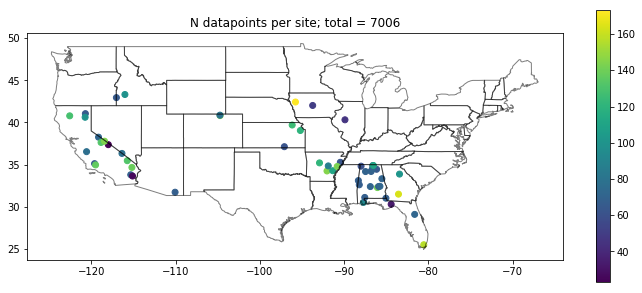

In [51]:
fig, ax = plt.subplots(figsize = (12,5))

ax.set_title("N datapoints per site; total = {}".format(sum(site_lens.values())))
gdf.plot(ax = ax, column = "len", legend = True)
states.plot(ax = ax, color = "none", edgecolor = "black", alpha = 0.5,  linewidth = 1)
plt.show()

In [52]:
D = {}
for k,v in nlcd.items():
    t = df[df.lc_type == k]
    if len(t) == 0:
        continue
    else:
        D[v] = len(t)

Text(85.875, 0.5, 'n samples')

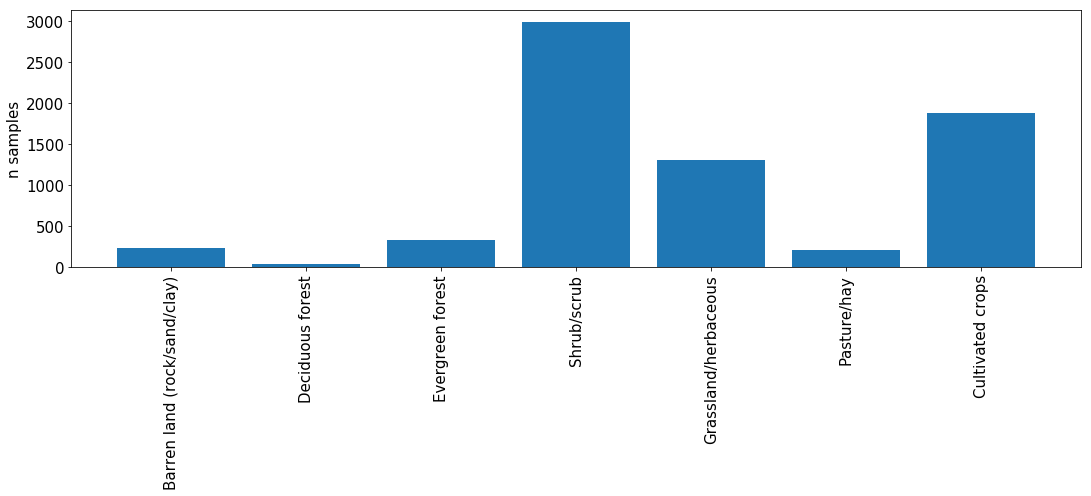

In [53]:
plt.figure(figsize = (15,7))
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()), rotation='vertical', size = 15)
plt.yticks(size = 15)
plt.tight_layout()
plt.ylabel("n samples", size = 15)

In [56]:
ts = []
for k,v in nlcd.items():
    t = df[df.lc_type == k]
    ts.append(t)

In [59]:
lcdf = pd.concat(ts)

In [66]:
join_cols = ["id","elev", "clay_fract", "silt_fract", "sand_fract", "a", "b"]
sites[join_cols]

,id,elev,clay_fract,silt_fract,sand_fract,a,b
16,2057,860,48.0,31.0,21.0,0.000130,-8.992373
17,2078,798,48.0,31.0,21.0,0.000130,-8.992373
18,2177,269,38.0,32.0,30.0,0.000121,-7.537208
19,2113,799,25.0,13.0,62.0,0.000005,-7.875624
20,2174,160,63.0,24.0,13.0,0.000080,-12.322121
21,2055,730,25.0,13.0,62.0,0.000005,-7.875624
22,2173,603,47.0,30.0,23.0,0.000114,-8.910207
23,2180,135,7.0,9.0,84.0,0.000029,-4.969597
24,2114,144,26.0,38.0,36.0,0.000241,-5.814689
25,2178,220,38.0,32.0,30.0,0.000121,-7.537208


In [ ]:
def read_sm_file(filename):
    with open(filename) as f:
        contents = f.readlines()

    data = []
    for line in contents:
        if line[0:1] == "#":
            continue
        else:
            data.append(line)

    headers = [x.replace("Soil Moisture Percent","smp").replace(" ","_") for x in data[0].split(",")]
    cols = [x.strip("\n").split(",") for x in data[1:]]

    df = pd.DataFrame(cols, columns = headers)
    
    return df

for idx, row in sites.iterrows():
    
    if row.id in out_dict.keys():
        print(row.id)
        continue
        
    print("Processings site no {}".format(row.id))
    
    # Make geom to submit to EE 
    x,y = row.geometry.buffer(0.0001).envelope.exterior.coords.xy
    coords = [list(zip(x,y))]
    area = ee.Geometry.Polygon(coords)
    
    # Get the corresponding SCAN data file from data folder
    site_id = row.id
    sm_file = [os.path.join(data_dir,x) for x in os.listdir(data_dir) if site_id in x][0]
    sm_dat = read_sm_file(sm_file)
    sm_dat['Date'] =  pd.to_datetime(sm_dat['Date'], format='%Y%m%d %H:%M')
    sm_dat.set_index('Date', inplace=True)

In [17]:
# Calculate spectral indices

df['ndvi'] = (df.B5 - df.B4) / (df.B5 + df.B4)
df["ndmi"] = (df.B5 - df.B6) / (df.B5 + df.B6)
df["evi"] = 2.5*(df.B5 - df.B4) / (df.B5 + 6*df.B4- 7.5*df.B2 + 1)


In [18]:
# For the backscatter columns (df.vv, df.hv), delete any zeros, nans, deal with weird formatting, and calc the mean 

vv_eff = []

for i in df.vv:
    line = i.replace("[","")
    line = line.replace("]","")
    line = ' '.join(line.split())
    data = [float(i) for i in line.split(' ')]
    data = [i for i in data if i !=0.]
    vv_eff.append(np.nanmean(data))
    

hv_eff = []

for i in df.hv:
    if type(i) is float:
        hv_eff.append(np.nan)
    else:
        line = i.replace("[","")
        line = line.replace("]","")
        line = ' '.join(line.split())
        data = [float(i) for i in line.split(' ')]
        data = [i for i in data if i !=0.]
        hv_eff.append(np.nanmean(data))

/Users/aakashahamed/anaconda3/envs/gis/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/Users/aakashahamed/anaconda3/envs/gis/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice


In [19]:
df['vv'] = vv_eff
df['hv'] = hv_eff

In [20]:
for i in df.site.unique():
    sdf = df[df.site==i]
    dr = pd.date_range(start = sdf.index[0], end = sdf.index[-1], freq = "12D")
    dt_idx = pd.DataFrame(dr)
    dt_df = rs.col_to_dt(dt_idx)
    fdf = pd.merge(dt_df, sdf, how = "inner", left_index = True, right_index = True)

In [21]:
def most_frequent(List): 
    counter = 0
    num = List[0] 
      
    for i in List: 
        curr_frequency = List.count(i) 
        if(curr_frequency> counter): 
            counter = curr_frequency 
            num = i 
  
    return num 

site_lags = {}
for j in df.site.unique():
    sdf = df[df.site==j]
    lags = []
    for i,x in enumerate(sdf.index[:-1]):
        lags.append((sdf.index[i+1] - sdf.index[i]).days)
    site_lags[j] = most_frequent(lags)
    
l = pd.DataFrame.from_dict(list(site_lags.items()))
l.columns = ['site_id', 'lags']


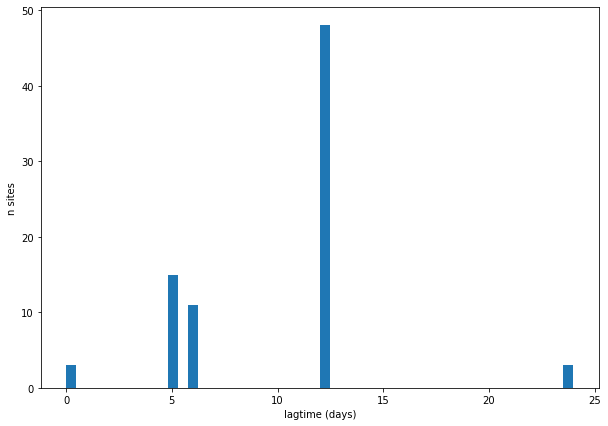

In [22]:
plt.figure(figsize = (10,7))
plt.hist(site_lags.values(), bins = 50)
plt.xlabel("lagtime (days)")
plt.ylabel("n sites")
plt.show()

In [23]:
gdf2 = pd.merge(sites,l,how = "inner", left_index = True, right_index = True)

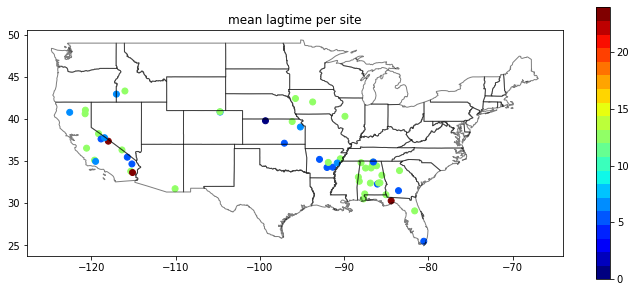

In [24]:
fig, ax = plt.subplots(figsize = (12,5))

cmap = plt.get_cmap('jet', 20)

ax.set_title("mean lagtime per site")
gdf2.plot(ax = ax, column = "lags", cmap = cmap, legend = True)
states.plot(ax = ax, color = "none", edgecolor = "black", alpha = 0.5,  linewidth = 1)
plt.show()

In [25]:
lag_lens = []
for i in df.site.unique():
    sdf = df[df.site==i]
    for i in sdf.index[2:-1]:
        end = i
        begin = end - pd.Timedelta(weeks=5)
        lag_lens.append(len(sdf.loc[begin:end]))

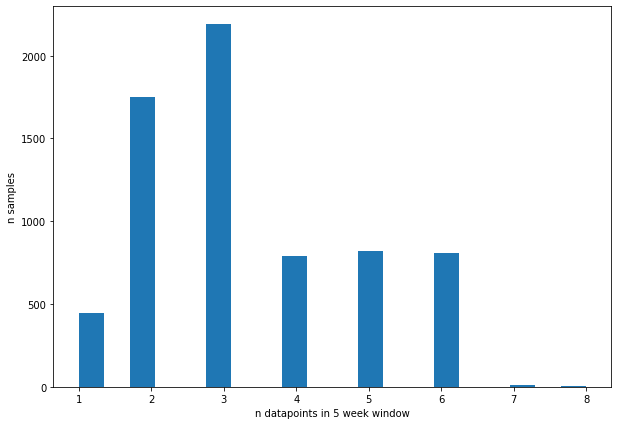

In [26]:
plt.figure(figsize = (10,7))
plt.hist(lag_lens, bins = 20)
plt.xlabel("n datapoints in 5 week window")
plt.ylabel("n samples")
plt.show()


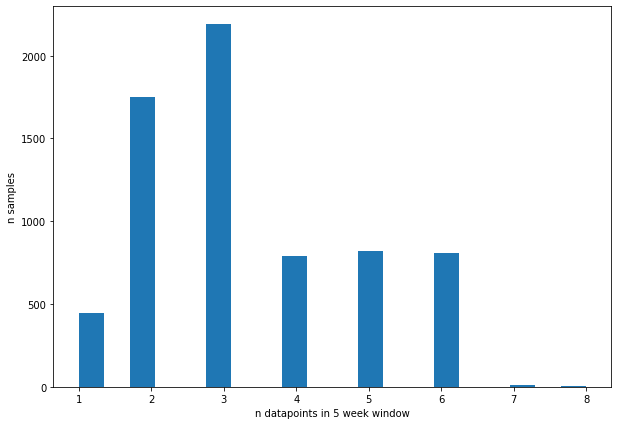

In [27]:
plt.figure(figsize = (10,7))
plt.hist(lag_lens, bins = 20)
plt.xlabel("n datapoints in 5 week window")
plt.ylabel("n samples")
plt.show()


In [28]:
def calc_n_rows(window_size):
    filtered = []

    for i in df.site.unique():
        sdf = df[df.site==i]

        for i in sdf.index:                
            end = i
            begin = end - pd.Timedelta(days=window_size)
            t = sdf[sdf.date.between(begin, end)]
            num_points = len(t)
            if num_points>6:
                filtered.append(t)

    f = pd.concat(filtered).drop_duplicates(subset=['date', 'site'])
    
    return len(f)/2

In [29]:
nrows = []
windows = np.linspace(30,60,31)

In [30]:
for i in windows:
    nrows.append(calc_n_rows(i))

Text(0.5, 0, 'timelag(days)')

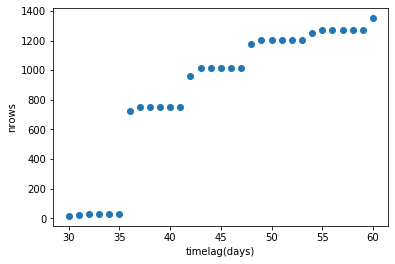

In [31]:
plt.scatter(windows, nrows)
plt.ylabel("nrows")
plt.xlabel("timelag(days)")

In [33]:
# calc the 12 day means for each site: 

len(df.groupby(['site']).resample('12D').mean().fillna(np.nan).dropna())


3131

In [39]:
def compute_lags(df, n=3):
    df['vv_t1'] = df['vv'].shift(1)
    df['hv_t1'] = df['hv'].shift(1)
    df['vv_t2'] = df['vv'].shift(2)
    df['hv_t2'] = df['hv'].shift(2)
    df['vv_t3'] = df['vv'].shift(3)
    df['hv_t3'] = df['hv'].shift(3)

    return df

In [40]:
fdf = df.groupby(['site']).resample('12D').mean().fillna(np.nan)

In [180]:
t = compute_lags(fdf)
# f = t.dropna()

In [276]:
df

site  precip   rzsm     psi_rz        ssm       psi_s  \
site date                                                                  
581  2017-03-27   581.0  0.3789  16.74   8.855681  16.910000    8.460846   
     2017-04-08   581.0  0.0000  16.91   8.427428  15.770000   11.836720   
     2017-04-20   581.0  0.0000  16.58   9.261036  16.000000   10.984226   
     2017-05-02   581.0  0.0000  16.46   9.589095  14.870000   15.784677   
     2017-05-14   581.0  0.0000  16.26  10.167661  10.766667   73.319758   
...                 ...     ...    ...        ...        ...         ...   
2219 2018-10-06  2219.0  0.0000  16.26   1.674752   9.000000   60.468818   
     2018-10-18  2219.0  0.0000  16.24   1.687297   8.760000   71.237281   
     2018-10-30  2219.0  0.0000  16.24   1.687297   8.400000   91.878438   
     2018-11-11  2219.0  0.0000  15.96   1.878989   8.060000  118.052684   
     2018-11-23  2219.0  0.0000  15.46   2.274093   8.180000  107.919878   

                 lc_type         vv         hv        B1  ...   B7_filt  \
site date                                                 ...             
581  2017-03-27     12.0 -18.414362 -26.428078  0.060900  ...  0.183503   
     2017-04-08     12.0 -21.098668 -28.563906  0.058133  ...  0.202161   
     2017-04-20     12.0 -14.140787 -25.063964  0.055367  ...  0.218480   
     2017-05-02     12.0 -19.289724 -26.336286  0.052600  ...  0.229020   
     2017-05-14     12.0 -23.238729 -25.587559  0.066500  ...  0.229251   
...                  ...        ...        ...       ...  ...       ...   
2219 2018-10-06     12.0 -22.239377 -40.472390  0.033437  ...  0.183351   
     2018-10-18     12.0 -20.269836 -36.267292  0.038300  ...  0.177168   
     2018-10-30     12.0 -20.841667 -34.286330  0.038300  ...  0.177168   
     2018-11-11     12.0 -21.522600 -37.597435  0.045966  ...  0.169601   
     2018-11-23     12.0 -18.645305 -25.355481  0.036555  ...  0.160650   

                     ndvi      ndmi       evi      vv_t1      hv_t1  \
site date                                                             
581  2017-03-27  0.206478 -0.271245  0.116138 -14.598647 -19.902440   
     2017-04-08  0.225829 -0.250664  0.125612 -18.414362 -26.428078   
     2017-04-20  0.245818 -0.228878  0.135180 -21.098668 -28.563906   
     2017-05-02  0.266478 -0.205778  0.144844 -14.140787 -25.063964   
     2017-05-14  0.291343 -0.156808  0.193437 -19.289724 -26.336286   
...                   ...       ...       ...        ...        ...   
2219 2018-10-06  0.237884 -0.217453  0.117921 -21.400197 -27.520323   
     2018-10-18  0.226527 -0.202627  0.114403 -22.239377 -40.472390   
     2018-10-30  0.226527 -0.202627  0.114403 -20.269836 -36.267292   
     2018-11-11  0.154940 -0.141003  0.090078 -20.841667 -34.286330   
     2018-11-23  0.193794 -0.216603  0.086057 -21.522600 -37.597435   

                     vv_t2      hv_t2      vv_t3      hv_t3  
site date                                                    
581  2017-03-27 -18.222244 -32.693216 -18.446447 -35.859314  
     2017-04-08 -14.598647 -19.902440 -18.222244 -32.693216  
     2017-04-20 -18.414362 -26.428078 -14.598647 -19.902440  
     2017-05-02 -21.098668 -28.563906 -18.414362 -26.428078  
     2017-05-14 -14.140787 -25.063964 -21.098668 -28.563906  
...                    ...        ...        ...        ...  
2219 2018-10-06 -18.723478 -33.442446 -22.615281 -25.793511  
     2018-10-18 -21.400197 -27.520323 -18.723478 -33.442446  
     2018-10-30 -22.239377 -40.472390 -21.400197 -27.520323  
     2018-11-11 -20.269836 -36.267292 -22.239377 -40.472390  
     2018-11-23 -20.841667 -34.286330 -20.269836 -36.267292  

[1853 rows x 32 columns]

In [270]:
# Filter out nonconsecutive dates
filtered = []

for i in t.site.unique():
    sdf = t[t.site==i]

    for i in sdf.index:   
        end = i[1]
        begin = end - pd.Timedelta(days=24)
        t = sdf[sdf.index.between(begin, end)]
        num_points = len(t)
        if num_points>6:
            filtered.append(t)


AttributeError: 'MultiIndex' object has no attribute 'between'

In [182]:
df = None
df = t.dropna()

In [183]:
# One hot encode the landcover types 
# one_hot = pd.get_dummies(df.lc_type, drop_first=True )
# X = pd.concat([X, one_hot], axis = 1)

In [184]:
# Select dependent variable, drop fluff from input (independent) feats
y = df.psi_rz # Psi_RZ? 
X = df.drop(["site","rzsm", "ssm", "psi_rz", "psi_s", "lc_type"], axis=1)

In [185]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
y = scaler.fit_transform(np.array(y).reshape(-1, 1))

In [186]:
# Train test split for validation 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Scale inputs
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [187]:
X_train.shape

(1482, 26)

In [189]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [242]:
# Modeling options
EPOCHS = int(20e3)
BATCHSIZE = int(2e5)
DROPOUT = 0.25
LOSS = 'mse'

Areg = regularizers.l2(1e-5)
Breg = regularizers.l2(1e-3)
Kreg = regularizers.l2(1e-15)
Rreg = regularizers.l2(1e-15)

In [243]:
def build_model(input_shape=(X_train.shape[0], X_train.shape[1])):
    
    model = Sequential()
    
    model.add(LSTM(10, input_shape=input_shape, dropout = DROPOUT,recurrent_dropout=DROPOUT,\
                  return_sequences=True, \
                  bias_regularizer= Breg))
    
    model.add(LSTM(10, input_shape=input_shape, dropout = DROPOUT,recurrent_dropout=DROPOUT,\
                    return_sequences=True, \
                    bias_regularizer= Breg))
    
    model.add(LSTM(10, input_shape=input_shape, dropout = DROPOUT,recurrent_dropout=DROPOUT,\
                   bias_regularizer= Breg))

    model.add(Dense(1))
    
    model.compile(loss=LOSS, optimizer='adam')
    # fit network
    
    return model

In [84]:
# model = build_model()

In [254]:
# create and fit the LSTM network

input_shape=(X_train.shape[1], X_train.shape[2])

model = Sequential()

model.add(LSTM(100, input_shape=input_shape, dropout = DROPOUT,recurrent_dropout=0.05,\
              return_sequences=True, \
              bias_regularizer= Breg))
model.add(LSTM(50, input_shape=input_shape, dropout = DROPOUT,recurrent_dropout=0.05,\
                return_sequences=True, \
                bias_regularizer= Breg))
model.add(LSTM(10, input_shape=input_shape, dropout = DROPOUT,recurrent_dropout=0.05,\
               bias_regularizer= Breg))

model.add(Dense(1))
model.compile(loss="mape", optimizer='adam')

In [ ]:
model.fit(X_train, y_train, epochs=500, batch_size=10, verbose=1)

Epoch 1/500
1482/1482 [==============================] - 1s 429us/step - loss: 147723.4327
Epoch 2/500
1482/1482 [==============================] - 1s 427us/step - loss: 105095.0277
Epoch 3/500
1482/1482 [==============================] - 1s 419us/step - loss: 163640.0883
Epoch 4/500
1482/1482 [==============================] - 1s 451us/step - loss: 87058.5782
Epoch 5/500
1482/1482 [==============================] - 1s 431us/step - loss: 85802.5612
Epoch 6/500
1482/1482 [==============================] - 1s 452us/step - loss: 86110.7991
Epoch 7/500
1482/1482 [==============================] - 1s 417us/step - loss: 106487.7549
Epoch 8/500
1482/1482 [==============================] - 1s 406us/step - loss: 118788.3062
Epoch 9/500
1482/1482 [==============================] - 1s 428us/step - loss: 145674.2260
Epoch 10/500
1482/1482 [==============================] - 1s 437us/step - loss: 69334.9110
Epoch 11/500
1482/1482 [==============================] - 1s 544us/step - loss: 114318.1928
E

In [257]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(y_train)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(y_test)

In [258]:

trainScore = math.sqrt(mean_squared_error(y_train, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1226290618973276.75 RMSE
Test Score: 1226407794644462.25 RMSE


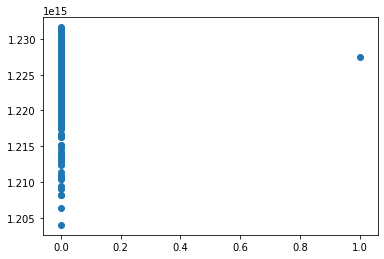

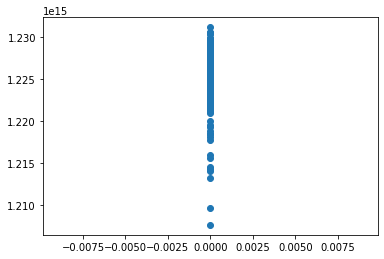

In [259]:
plt.scatter(y_train, trainPredict)
plt.show()
plt.scatter(y_test, testPredict)
plt.show()

In [ ]:
# Run the actual RF 

regressor = RandomForestRegressor(n_estimators=5000, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [ ]:
# Make predictions on test data using the model trained on original data
predictions = regressor.predict(X_test)
# Performance metrics
errors = abs(predictions - y_test)
print('Metrics for Random Forest Trained on Original Data')
print('Average absolute error:', round(np.mean(errors), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')